# MNIST Classifier Neural Net
A basic handwriting recognition neural net that learns to classify hand-written digits from the MNIST dataset

In [ ]:
!pip3 install torch torchvision matplotlib --quiet

### Download & prepare the MNIST dataset
The "datasets" pytorch can be used to fetch the dataset 

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Download and normalize the 60,000 training images, and 10,000 test images
training_data = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
testing_data = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

# Initialize data loaders to load the images and labels for the network
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=True)

### Model definition: define the structure of the neural network
In `__init__` we describe each layer, defining the number of inputs and outputs.
The input layer does not need to be defined, since the input layer is just the flattened 784-long vector that describes the image.

In [2]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 20) # define hidden layer dimensions: 784 inputs, 20 outputs
        self.fc2 = nn.Linear(20, 10) # define output layer dimensions: 20 inputs, 10 outputs

    def forward(self, inputs):
        input_layer = inputs.view(inputs.shape[0], -1) # flatten the 28x28 images into a 784-long vector
        hidden_layer = F.sigmoid(self.fc1(input_layer)) # apply sigmoid to hidden layer
        output_layer = F.log_softmax(self.fc2(hidden_layer), dim=1) # apply softmax to output layer
        return output_layer

### Initialize the neural net, loss function, and optimizer
Here we'll initialize the network we defined above, the function used for calculating loss, and the optimizer that will adjust the weights.
- Since our output layer is a probability distribution created using the `softmax` function, we need to use the "negative log likelihood loss" (NLL Loss) function.
- The optimizer is the function that makes all the weight adjustments 
- The optimizer we're using is called "stochastic gradient descent" (SGD), one of the most popular and commonly used optimizers in machine learning.

In [3]:
# Initialize network, error/loss function, and weight weights_optimizer
model = NeuralNet()
loss_function = nn.NLLLoss() # Calculates the loss (error) of the network
weights_optimizer = optim.SGD(model.parameters(), lr=0.05) # Updates the weights of the network

### Define the training script
Our training script is a simple nested loop. 
- The inner loop does a forward->backward pass for each sample in the training dataset, so it runs 60,000 times
    - One run of the inner loop is one training **iteration**
- The outer loop is set to run until the loss reaches an acceptable minimum
    - One run of the outer loop is one training **epoch**

In [4]:
# Training loop
for epoch in range(10): # loop over the whole dataset 10 times
    running_loss = 0.0
    for images, labels in train_loader:
        # reset the optimizer
        weights_optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # backward pass (backpropagation)
        loss.backward()
        weights_optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch: %d loss: %.3f' %
          (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')

Epoch: 1 loss: 1.486
Epoch: 2 loss: 0.646
Epoch: 3 loss: 0.467
Epoch: 4 loss: 0.397
Epoch: 5 loss: 0.358
Epoch: 6 loss: 0.333
Epoch: 7 loss: 0.314
Epoch: 8 loss: 0.300
Epoch: 9 loss: 0.287
Epoch: 10 loss: 0.277
Finished Training


### Test our trained model using the test dataset
We can test our trained neural net with images from the test dataset. Remember that the network hasn't seen any of the examples in the test dataset.

We'll use `matplotlib` to visualize each digit and the probability distribution produced by our network

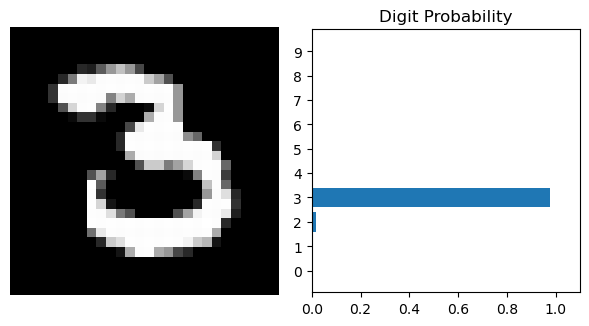

In [10]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Function to predict the digit in an image
def predict_image(image):
    image = image.view(1, 784)  # reshape the image to match model input shape
    with torch.no_grad():
        logps = model(image)  # log probabilities
    ps = torch.exp(logps)  # convert to probabilities
    _, predicted = torch.max(ps, 1)  # get the index of the max probability
    return predicted.item(), ps

# Function to view an image and its predicted classes
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Digit Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# Get a random batch of images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Take the first image from the batch
image = images[0] 
# Predict the digit in the image
predicted, ps = predict_image(image)
# View the image and its classification probabilities
view_classify(image, ps)
